In [2]:

from ephysvibe.structures.trials_data import TrialsData
import numpy as np
from ephysvibe.task import task_constants,def_task
from ephysvibe.spike_sorting import utils_oe
from sklearn.decomposition import PCA
from numpy.core.umath import (
    pi, add, arctan2, frompyfunc, cos, less_equal, sqrt, sin,
    mod, exp, not_equal, subtract
    )
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import hilbert, butter, sosfilt, filtfilt
import numpy as np
from scipy.fft import fft, fftfreq, ifft
import h5py
import scipy as sp
import numpy.core.numeric as _nx
from mne import time_frequency, create_info, EpochsArray
from phylib.io.traces import get_ephys_reader

In [3]:
def rolling_window(a, window, step):    
    shape = a.shape[:-1] + ((a.shape[-1] - window + 1)//step, window)    
    strides = (a.strides[0] * step,) + (a.strides[-1],)    
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

### Def gp functions

In [4]:
def mat_select_seg(lfp,spk,i_seg):
    sp_bool = np.zeros((32,10000))
    for i,i_sp in enumerate(spk):
        mask = np.logical_and(i_sp>=i_seg,i_sp<i_seg+10000)
        sp_bool[i,i_sp[mask]-1-i_seg]=1

    seg_lfp = lfp[:,i_seg:i_seg+10000]#TrialsData.indep_roll(data.lfp_values[trial_idx], shifts, axis=2)
    #TrialsData.indep_roll(data.sp_samples[trial_idx], shifts, axis=2)
    #.shape[1]
    return seg_lfp, sp_bool

In [5]:
def rewrap(p):
    p = (p - 2*np.pi * np.floor( (p-np.pi) / (2*np.pi)) - 2*np.pi )
    return p

In [6]:
def unwrap(p, discont=pi, axis=-1):
    """
    Unwrap by changing deltas between values to 2*pi complement.
    Unwrap radian phase `p` by changing absolute jumps greater than
    `discont` to their 2*pi complement along the given axis.
    Parameters
    ----------
    p : array_like
        Input array.
    discont : float, optional
        Maximum discontinuity between values, default is ``pi``.
    axis : int, optional
        Axis along which unwrap will operate, default is the last axis.
    Returns
    -------
    out : ndarray
        Output array.
    See Also
    --------
    rad2deg, deg2rad
    Notes
    -----
    If the discontinuity in `p` is smaller than ``pi``, but larger than
    `discont`, no unwrapping is done because taking the 2*pi complement
    would only make the discontinuity larger.
    Examples
    --------
    """
    p = np.asarray(p)
    nd = p.ndim
    dd = np.diff(p, axis=axis)
    slice1 = [slice(None, None)]*nd     # full slices
    slice1[axis] = slice(1, None)
    slice1 = tuple(slice1)
    ddmod = mod(dd + pi, 2*pi) - pi
    _nx.copyto(ddmod, pi, where=(ddmod == -pi) & (dd > 0))
    ph_correct = ddmod - dd
    _nx.copyto(ph_correct, 0, where=abs(dd) < discont)
    up = np.array(p, copy=True, dtype='d')
    up[slice1] = p[slice1] + ph_correct.cumsum(axis)
    return up

In [7]:
def compute_generalized_phase(x,dt):
    # Handle input
    # x = np.reshape(x, [1,1,-1])
    [nch, npts] = x.shape
    # Analytic signal representation (single sided Fourier representation)
    x0 = fft(x,npts,axis=1)
    h = np.zeros((nch,npts))
    # ! improve:
    if npts >0 and np.mod(npts,2)==0:
        h[:,0:npts//2] = 1
        h[:,1:npts//2-1] = 2
    else:
        h[:,0] = 1
        h[:,1:npts//2] = 2
    x0 = ifft(x0*h,axis=1)
    ph = np.angle(x0)
    md = np.abs(x0)

    # Calculate IF
    wt = np.zeros(x0.shape)
    wt[:,0:-1] = np.angle(x0[:,1:] * np.conj(x0[:,:-1])) / (2*np.pi*dt) 

    # Rectify rotation
    # ! This can be improved
    sign_if = np.sign(np.nanmean(wt,axis=1))
    for i,i_sign_if in enumerate(sign_if):
        if i_sign_if == -1:
            modulus = abs(x0[i])
            ang = i_sign_if * np.angle(x0[i])
            x0[i] = modulus * np.exp(1j * ang)
            ph[i] = np.angle(x0[i])
            md = abs(x0[i])
            wt[i,0:-1] = np.angle(x0[i,1:] * np.conj(x0[i,:-1])) / (2*np.pi*dt) 

    # # check if nan channels
    # if np.all(np.isnan(ph)):
    #     continue

    # Find negative freq epochs
    idx = (wt<0).astype(int)
    idx[:,0] = 0
    diff = np.diff(idx,axis=1)
    r_start, c_start = np.where(diff == 1)
    r_end, c_end = np.where(diff == -1)
    duration = c_end-(c_start+1)
    [start,end] = c_start + 1, (c_start+1+duration*3)+1
    for i, i_r_start in enumerate(r_start):
        idx[i_r_start,start[i]:end[i]] = 1

    ph[idx.astype(bool)] = np.nan
    if ~np.all(np.isnan(ph)):
        for i,i_ph in enumerate(ph):
            not_nan = ~np.isnan(i_ph)
            ph[i,not_nan] = unwrap(i_ph[not_nan])

        dx = np.linspace(0,1,npts)
        isnan = np.isnan(ph)
        for i, i_ch in enumerate(ph):
            if np.sum(~np.isnan(i_ch))<2:
                continue
            f = sp.interpolate.PchipInterpolator(dx[~isnan[i]],ph[i,~isnan[i]])
            ph[i,isnan[i]] = f(dx[isnan[i]])
        ph = rewrap(ph)

    xgp = md * np.exp(1j * ph)

    return xgp, wt

In [8]:
def complex_mean(alpha, w=None, axis=None, axial_correction=1):    
    if w is None:        
        w = np.ones_like(alpha)    
        alpha = np.asarray(alpha)
    assert w.shape == alpha.shape, "Dimensions of data " + str(alpha.shape)  + " and w " +   str(w.shape) + " do not match!"
    
    return ((w * np.exp(1j * alpha * axial_correction)).sum(axis=axis) /  np.sum(w, axis=axis))

In [9]:
def mean_direction(alpha, w=None, ci=None, d=None, axis=None, axial_correction=1):
    """
    Compute mean direction of circular data.
    :param alpha: circular data
    :param w: 	 weightings in case of binned angle data
    :param ci: if not None, the upper and lower 100*ci% confidence
               interval is returned as well
    :param d: spacing of bin centers for binned data, if supplied
              correction factor is used to correct for bias in
              estimation of r, in radians (!)
    :param axis: compute along this dimension, default is None
                 (across all dimensions)
    :param axial_correction: axial correction (2,3,4,...), default is 1
    :return: circular mean if ci=None, or circular mean as well as lower and
             upper confidence interval limits

    """

    cmean = complex_mean(alpha,
                          w=w,
                          axis=axis,
                          axial_correction=axial_correction)

    mu = np.angle(cmean) / axial_correction

    if ci is None:
        return mu
    else:
        if axial_correction > 1:  
            print("Axial correction ignored for confidence intervals.")
        #t = mean_ci_limits(alpha, ci=ci, w=w, d=d, axis=axis)
        return mu#, CI(mu - t, mu + t)


In [10]:
def center(*args, **kwargs):
    """
    Centers the data on its circular mean.
    Each non-keyword argument is another data array that is centered.
    :param axis: the mean is computed along this dimension (default axis=None).
                **Must be used as a keyword argument!**
    :return: tuple of centered data arrays
    """

    axis = kwargs.pop('axis', None)
    if axis is None:
        axis = 0
        args = [a.ravel() for a in args]

    reshaper = tuple(slice(None, None) if i != axis else np.newaxis
                     for i in range(len(args[0].shape)))
    if len(args) == 1:
        return args[0] - mean_direction(args[0], axis=axis)
    else:
        return tuple([a - mean_direction(a, axis=axis)[reshaper]
                      for a in args if isinstance(a, np.ndarray)])

In [11]:
def resultant_vector_length(alpha, w=None, d=None, axis=None, axial_correction=1, ci=None, bootstrap_iter=None):    
    """    Computes mean resultant vector length for circular data.    
    This statistic is sometimes also called vector strength.    
    :param alpha: sample of angles in radians    
    :param w: number of incidences in case of binned angle data    
    :param ci: ci-confidence limits are computed via bootstrapping,               
    default None.    
    :param d: spacing of bin centers for binned data, if supplied              
    correction factor is used to correct for bias in              
    estimation of r, in radians (!)    
    :param axis: compute along this dimension, default is None                 
    (across all dimensions)    
    :param axial_correction: axial correction (2,3,4,...), default is 1    
    :param bootstrap_iter: number of bootstrap iterations                          
    (number of samples if None)    
    :return: mean resultant length    
    References: [Fisher1995]_, [Jammalamadaka2001]_, [Zar2009]_    """    
    if axis is None:        
        axis = 0        
        alpha = alpha.ravel()        
        if w is not None:            
            w = w.ravel()
    cmean = complex_mean(alpha, w=w, axis=axis,axial_correction=axial_correction)
    # obtain length    
    r = np.abs(cmean)
    # for data with known spacing, apply correction factor to correct for bias    
    # in the estimation of r (see Zar, p. 601, equ. 26.16)    
    if d is not None:        
        if axial_correction > 1:            
            print("Axial correction ignored for bias correction.")        
        r *= d / 2 / np.sin(d / 2)    
    return r
# defines synonym for resultant_vector_lengthvector_strength = resultant_vector_length

In [12]:
def corrcc(alpha1, alpha2, ci=None, axis=None, bootstrap_iter=None):
    """
    Circular correlation coefficient for two circular random variables.
    If a confidence level is specified, confidence limits are bootstrapped.
    The number of bootstrapping iterations is min(number of data points
    along axis, bootstrap_max_iter).
    :param alpha1: sample of angles in radians
    :param alpha2: sample of angles in radians
    :param axis: correlation coefficient is computed along this dimension
                 (default axis=None, across all dimensions)
    :param ci: if not None, confidence level is bootstrapped
    :param bootstrap_iter: number of bootstrap iterations
                           (number of samples if None)
    :return: correlation coefficient if ci=None, otherwise correlation
             coefficient with lower and upper confidence limits
    References: [Jammalamadaka2001]_
    """
    assert alpha1.shape == alpha2.shape, 'Input dimensions do not match.'

    # center data on circular mean
    alpha1, alpha2 = center(alpha1, alpha2, axis=axis)

    # compute correlation coeffcient from p. 176
    num = np.sum(np.sin(alpha1) * np.sin(alpha2), axis=axis)
    den = np.sqrt(np.sum(np.sin(alpha1) ** 2, axis=axis) *
                  np.sum(np.sin(alpha2) ** 2, axis=axis))
    return num / den

### Def raw data functions

In [13]:
def load_continuous_dat(obj, **kwargs):
    """load continuous.dat.
    Parameters
    ----------
    obj : str or Path
        Path to the raw data file.
    sample_rate : float
        The data sampling rate, in Hz.
    n_channels_dat : int
        The number of columns in the raw data file.
    dtype : str
        The NumPy data type of the raw binary file.
    offset : int
        The header offset in bytes.
    """
    kwargs = {
        k: v for k, v in kwargs.items()
        if k in ('sample_rate', 'n_channels_dat', 'dtype', 'offset')}
    traces = get_ephys_reader(obj, **kwargs)
    
    return  traces

In [14]:
def filter_continuous(x,fs,fc_hp=None,fc_lp=None,axis=1):
    """Basic filtering of the continuous LFP before cutting it into epochs.
    The signal is expected to be already low-pass filtered at 250Hz
    """
    #fs_lfp = 30000  # sampling frequency of the signal in Hz
    #fc_hp = 250  # cut-off frequency of the high pass filter in Hz

    # perform a High pass filter - butterworth filter of order 6 at 1Hz
    if not(fc_hp is None):
        sos = butter(6, fc_hp, "hp", fs=fs, output="sos")
    else:
        sos = butter(6, fc_lp, "lp", fs=fs, output="sos")
    x_hp = sosfilt(sos, x)

    return x_hp

### Load data

In [15]:
#path = '/envau/work/invibe/USERS/IBOS/openephys/Riesling/2023-03-21_10-40-02/Record Node 102/experiment1/recording1/continuous/Acquisition_Board-100.Rhythm Data/'
continuous_path = '/envau/work/invibe/USERS/IBOS/openephys/Riesling/2023-03-21_10-40-02/Record Node 102/experiment1/recording1/continuous/Acquisition_Board-100.Rhythm Data/continuous.dat'
#event_path = "/envau/work/invibe/USERS/IBOS/openephys/Riesling/2023-03-21_10-40-02/Record Node 102/experiment1/recording1/events/Acquisition_Board-100.Rhythm Data/TTL"
#filepath = "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/Riesling/lip/2023-03-21_10-40-02_Riesling_lip_e1_r1.h5"
#s_path = os.path.normpath(filepath).split(os.sep)
#data = TrialsData.from_python_hdf5(filepath)
#events = load_event_files(event_path)
c_samples = np.load('/envau/work/invibe/USERS/IBOS/openephys/Riesling/2023-03-21_10-40-02/Record Node 102/experiment1/recording1/continuous/Acquisition_Board-100.Rhythm Data/sample_numbers.npy')
shape_0 = len(c_samples)

In [16]:
n_channels=163                       
sample_rate=30000
print(shape_0,n_channels)
args={'sample_rate':sample_rate,'n_channels_dat':n_channels,'dtype':"int16"}
cont = load_continuous_dat(continuous_path, **args)

172830658 163


In [17]:
fs = 1000
dt = 1/fs
order = 4
lp_f = 50
hp_f = 5
passband = [hp_f/(fs/2), lp_f/(fs/2)]

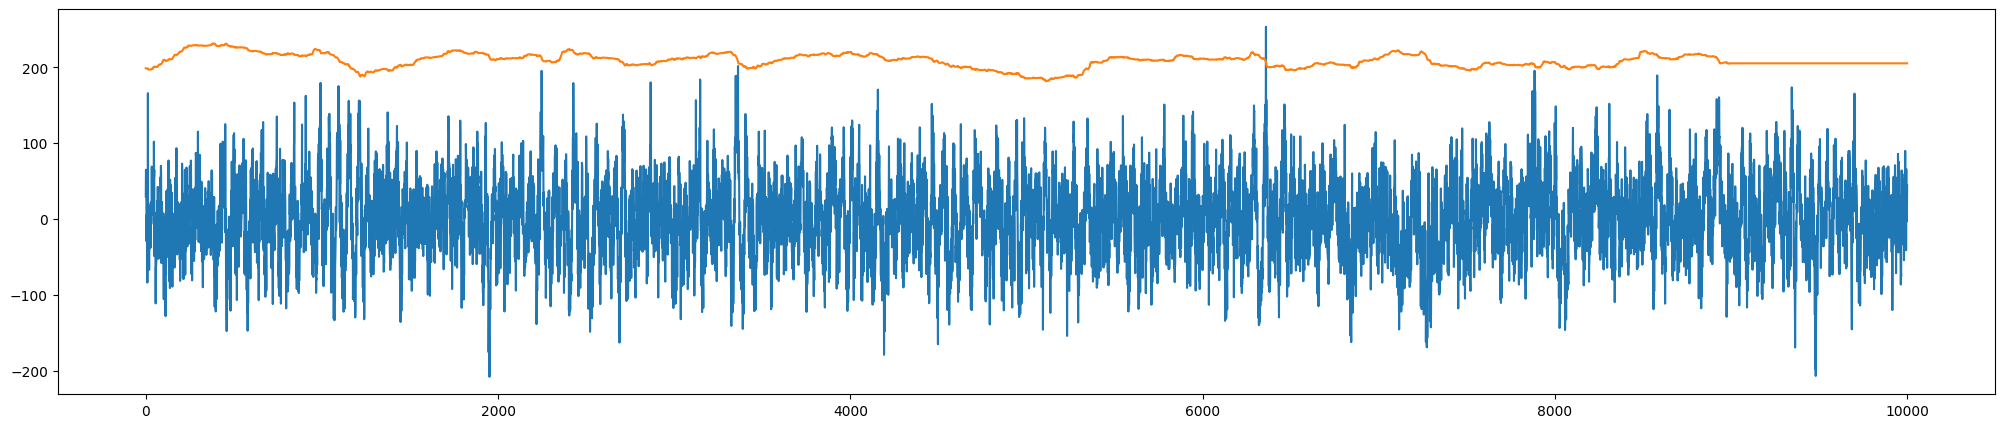

In [18]:
min_20 = 30*60*1000*30
min_50 = 50*60*1000*30
cont_hp = filter_continuous(cont[:300000],fs=30000,fc_hp=500,axis=0) # High pass filter
step=1
win = 30000
d_shape=cont_hp.shape
idx_ds = np.arange(0,300000,  30)
# Detect spikes using a threshold
fig,ax=plt.subplots(figsize=(25,5))
ch = 2
ax.plot(cont_hp[idx_ds,ch])

std = np.std(rolling_window(cont_hp[idx_ds,ch], window=1000, step=1),axis=1)
std = np.concatenate([std,np.full(999,std[-1])])

thresh = 4*std
ax.plot(thresh)
#ax.plot(diff*400)

In [19]:
def detect_spikes(seg_lp:np.ndarray)->np.ndarray:
    """Detect spikes using a threshold.

    Args:
        seg_lp (np.ndarray): _description_

    Returns:
        np.ndarray: _description_
    """
    # 
    shape_0,shape_1 = seg_lp.shape

    
    sp_seg = np.zeros((shape_0,shape_1))
    for ch in range(shape_0):
        # std in sliding win of 1 second
        std = np.std(rolling_window(seg_lp[ch], window=1000, step=1),axis=1)
        std = np.concatenate([std,np.full(999,std[-1])])

        idx = (seg_lp[ch]>=3*std).astype(int)
        idx[0] = 0
        diff = np.diff(idx)
        diff_start = np.where(diff == 1)[0]
        diff_end = np.where(diff == -1)[0]
        sp_ch_seg=[]
        for i_start, i_end in zip(diff_start,diff_end):
            sp_idx = seg_lp[ch,i_start:i_end+1]
            if len(sp_idx)== 0:
                print(' ')
            
            #if len(sp_idx) == 0:

            sp_ch_seg.append(np.argmax( sp_idx ) + i_start)
        sp_seg[ch][sp_ch_seg] = 1
    return sp_seg

In [20]:
min_20 = 60*60*1000*30
min_50 = 100*60*1000*30
seg = np.arange(0,int((min_50-min_20)/30),10000)
seg_phase_spikes = []
idx_ds = np.arange(0,300000-10000,  30)
n_channels=32
for i_seg in seg:
    #seg_lfp,seg_sp = mat_select_seg(all_lfp,all_sp,i_seg)
    # Select segment of the data 
    
    # spike data
    seg_hp = filter_continuous(cont[i_seg:i_seg+300000,:32],fs=30000,fc_hp=500,axis=0) # High pass filter
    ## subsample
    # subsample = idx_ds[i_seg:i_seg+10000].tolist()
    seg_hp = seg_hp[idx_ds,:32].T
    ## detect spikes
    seg_sp = detect_spikes(seg_hp)
    
    # lfp data
    seg_lp = filter_continuous(cont[i_seg:i_seg+300000,:n_channels],fs=30000,fc_lp=300,axis=0) # Low pass filter
    b, a = butter(4, passband, 'bandpass')
    x_lfp = filtfilt(b, a, seg_lp,padtype = 'odd', padlen=3*(max(len(b),len(a))-1),axis=0)
    x_lfp=x_lfp[idx_ds,:n_channels].T
    # compute gp
    xgp, wt = compute_generalized_phase(x_lfp,dt)
    phase_lfp = np.angle(xgp.astype(complex))

    # Spike phases
    phase_spikes = []#np.zeros(n_channels,n_channels)

    for lfp_ch in range(0,n_channels):
        
        ch_phase_spikes = []
        for sp_ch in range(0,n_channels):
            
            if np.sum(seg_sp[sp_ch]) !=0: # No spikes? No phase
                ch_phase_spikes.append(phase_lfp[lfp_ch,seg_sp[sp_ch].astype(bool)])
            else:
                ch_phase_spikes.append([np.nan])
        phase_spikes.append(ch_phase_spikes)
    
    seg_phase_spikes.append(phase_spikes)

In [21]:
ps = []
for lfp_ch in range(0,n_channels):
    ps_2 = []
    for sp_ch in range(0,n_channels):
        ps_1 = []
        for i_seg in np.arange(0,len(seg_phase_spikes)):
            ps_1.append(seg_phase_spikes[i_seg][lfp_ch][sp_ch])
        ps_2.append(np.concatenate(ps_1))
    ps.append(ps_2)

In [22]:
# spike phase index (SPI): 1 all spikes occur at a single phase, 0 perfectly uniform spike-phase distribution
spike_phase = np.full((n_channels,n_channels),np.nan)
pref_phase = np.full((n_channels,n_channels),np.nan)
phase_corr = np.full((n_channels,n_channels),np.nan)
for lfp_ch in range(0,n_channels):

    for sp_ch in range(0,n_channels):
        #phase_sp = np.concatenate(ps[lfp_ch][sp_ch])
        phase_sp = ps[lfp_ch][sp_ch][~np.isnan(ps[lfp_ch][sp_ch])]
        spike_phase[lfp_ch,sp_ch] = resultant_vector_length(alpha=phase_sp) 
        pref_phase[lfp_ch,sp_ch] = mean_direction(alpha=phase_sp)
        phase_corr[lfp_ch,sp_ch] = corrcc(phase_lfp[lfp_ch], phase_lfp[sp_ch])

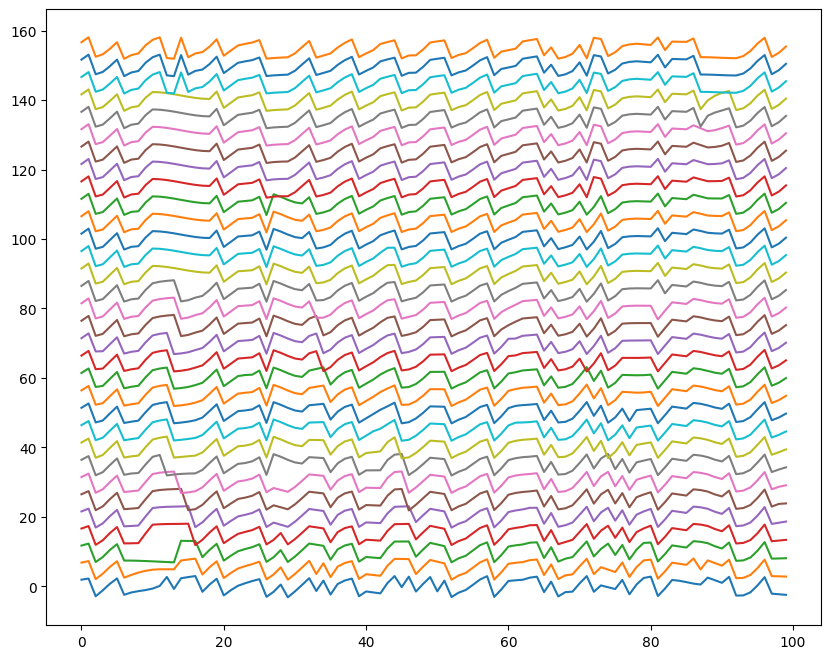

In [23]:
fig,ax = plt.subplots(figsize=(10,8))
a=ax.plot(phase_lfp[:,:100].T+np.arange(0,32*5,5))

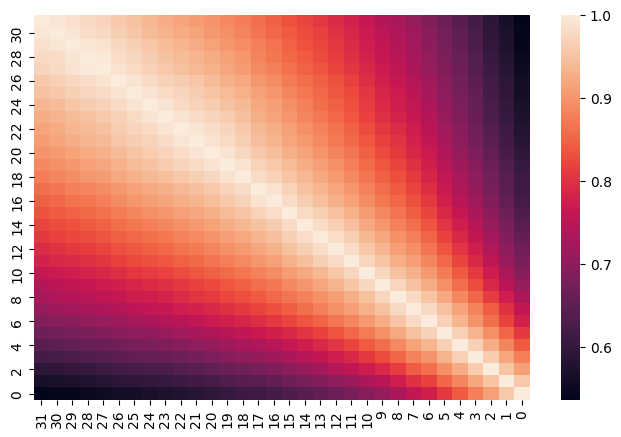

In [24]:
_,ax = plt.subplots(figsize=(8,5))
sns.heatmap(phase_corr)
ax.invert_yaxis()
ax.invert_xaxis()
plt.show()

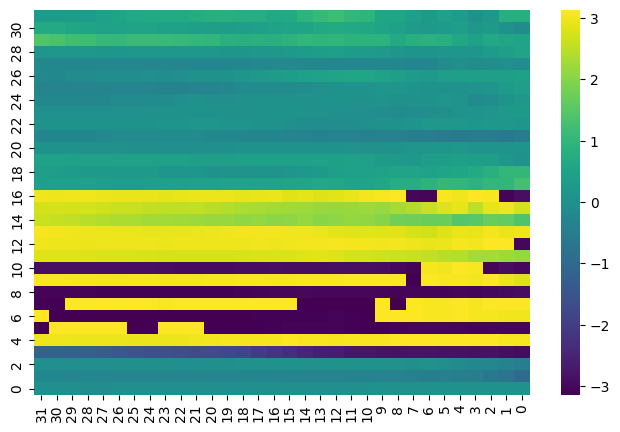

In [31]:
_,ax = plt.subplots(figsize=(8,5))
sns.heatmap(pref_phase.T,cmap='viridis')
ax.invert_yaxis()
ax.invert_xaxis()
plt.show()

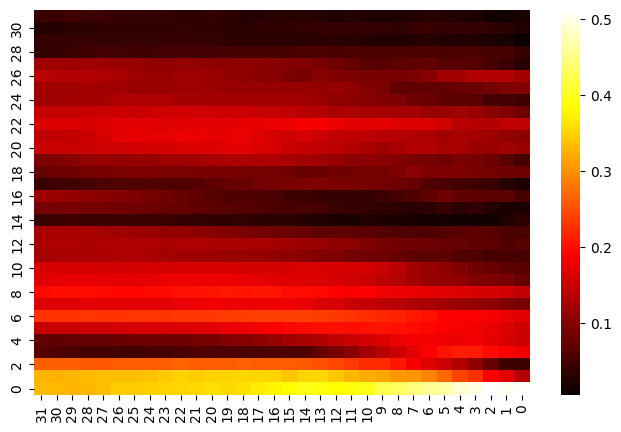

In [29]:
_,ax = plt.subplots(figsize=(8,5))
sns.heatmap(spike_phase.T,cmap='hot')
ax.invert_yaxis()
ax.invert_xaxis()
plt.show()

## Mat data

In [73]:
# Load Matlab data
f=sp.io.loadmat('/home/INT/losada.c/Downloads/exData3.mat')
spk = np.concatenate(f['spikeTimes'])
lfp = np.concatenate(f['LFP'][0])
permutation =np.flip(f['chanMap'].reshape(-1)-1)
all_lfp=lfp[ permutation,:] # return a rearranged copy
all_sp = spk[ permutation]

In [74]:
all_lfp.shape

(32, 2432288)

In [107]:
(2432288/1000)/60

40.538133333333334

In [75]:
fs = 1000
dt = 1/fs
order = 4
lp_f = 40
hp_f = 5
passband = [hp_f/(fs/2), lp_f/(fs/2)]

In [76]:
min_20 = 20*60*1000*30
min_50 = 50*60*1000*30

seg_phase_spikes = []

n_channels=32
n_seg = np.floor(np.max(all_lfp.shape)/(fs*10))*10000
seg = np.arange(0,n_seg,10000)
for i_seg in seg:
    
    seg_lfp,seg_sp = mat_select_seg(all_lfp,all_sp,int(i_seg))
    # Select segment of the data 
       
    # lfp data
    #seg_lp = filter_continuous(cont[i_seg:i_seg+300000,:n_channels],fs=30000,fc_lp=300,axis=0) # Low pass filter
    b, a = butter(4, passband, 'bandpass')
    x_lfp = filtfilt(b, a, seg_lfp,padtype = 'odd', padlen=3*(max(len(b),len(a))-1),axis=1)
    # x_lfp=x_lfp[idx_ds,:n_channels].T
    # compute gp
    xgp, wt = compute_generalized_phase(x_lfp,dt)
    phase_lfp = np.angle(xgp.astype(complex))

    # Spike phases
    phase_spikes = []#np.zeros(n_channels,n_channels)

    for lfp_ch in range(0,n_channels):
        
        ch_phase_spikes = []
        for sp_ch in range(0,n_channels):
            
            if np.sum(seg_sp[sp_ch]) !=0: # No spikes? No phase
                ch_phase_spikes.append(phase_lfp[lfp_ch,seg_sp[sp_ch].astype(bool)])
            else:
                ch_phase_spikes.append([np.nan])
        phase_spikes.append(ch_phase_spikes)
    
    seg_phase_spikes.append(phase_spikes)

In [77]:
ps = []
for lfp_ch in range(0,n_channels):
    ps_2 = []
    for sp_ch in range(0,n_channels):
        ps_1 = []
        for i_seg in np.arange(0,len(seg_phase_spikes)):
            ps_1.append(seg_phase_spikes[i_seg][lfp_ch][sp_ch])
        ps_2.append(np.concatenate(ps_1))
    ps.append(ps_2)

In [78]:
# spike phase index (SPI): 1 all spikes occur at a single phase, 0 perfectly uniform spike-phase distribution
spike_phase = np.full((n_channels,n_channels),np.nan)
pref_phase = np.full((n_channels,n_channels),np.nan)
phase_corr = np.full((n_channels,n_channels),np.nan)
for lfp_ch in range(0,n_channels):

    for sp_ch in range(0,n_channels):
        #phase_sp = np.concatenate(ps[lfp_ch][sp_ch])
        phase_sp = ps[lfp_ch][sp_ch][~np.isnan(ps[lfp_ch][sp_ch])]
        spike_phase[lfp_ch,sp_ch] = resultant_vector_length(alpha=phase_sp) 
        pref_phase[lfp_ch,sp_ch] = mean_direction(alpha=phase_sp)
        phase_corr[lfp_ch,sp_ch] = corrcc(phase_lfp[lfp_ch], phase_lfp[sp_ch])

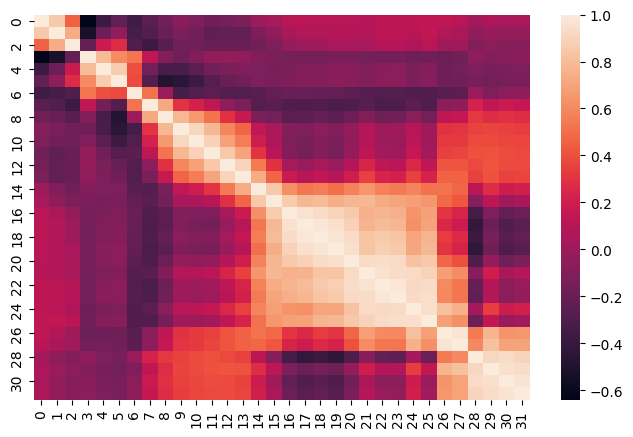

In [79]:
_,ax = plt.subplots(figsize=(8,5))
sns.heatmap(phase_corr)
#ax.invert_yaxis()
plt.show()

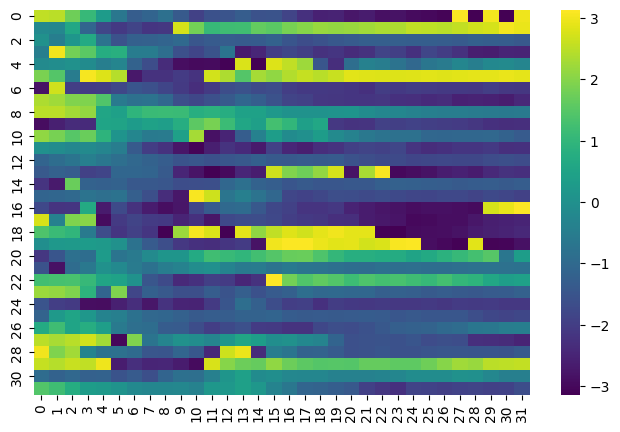

In [80]:
_,ax = plt.subplots(figsize=(8,5))
sns.heatmap(pref_phase.T,cmap='viridis')
plt.show()

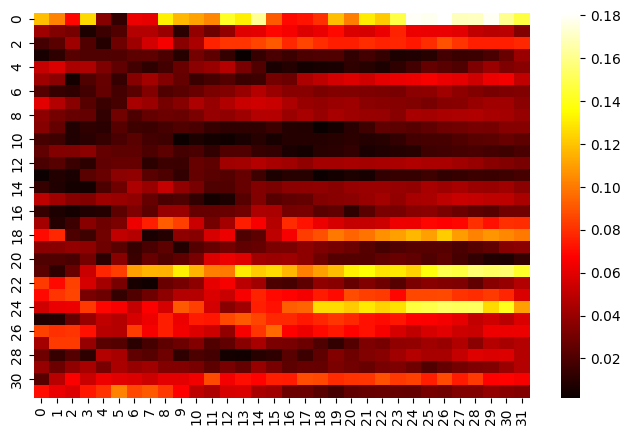

In [81]:
_,ax = plt.subplots(figsize=(8,5))
sns.heatmap(spike_phase.T,cmap='hot')
#ax.invert_yaxis()
plt.show()